# Machine learning in power systems

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import datetime
%matplotlib notebook

In [21]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [18]:
data = pickle.load(open('electricity_prices_belgium.pkl', "rb"))

# Visualize the data

In [19]:
print data.head()
print data.tail()

                           belpex  solar    wind
2013-12-31 23:00:00+00:00   15.15    0.0  780.10
2013-12-31 23:00:00+00:00   15.15    0.0  780.10
2013-12-31 23:15:00+00:00   15.15    0.0  781.09
2013-12-31 23:30:00+00:00   15.15    0.0  793.82
2013-12-31 23:45:00+00:00   15.15    0.0  824.23
                           belpex  solar    wind
2016-12-31 21:45:00+00:00   35.00    0.0  330.47
2016-12-31 22:00:00+00:00   34.94    0.0  347.93
2016-12-31 22:15:00+00:00   34.94    0.0  375.27
2016-12-31 22:30:00+00:00   34.94    0.0  376.38
2016-12-31 22:45:00+00:00   34.94    0.0  399.91


<IPython.core.display.Javascript object>


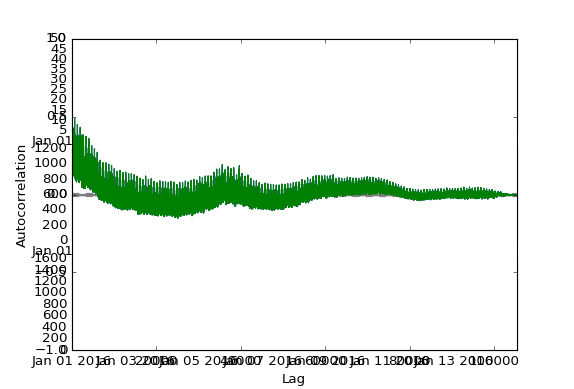

In [20]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 1, 14, 23, 45)

plt.figure(1)
plt.subplot(311)
plt.plot(data['belpex'][start:end], label='belpex')
plt.legend(frameon=False)
plt.subplot(312)
plt.plot(data['solar'][start:end], label='solar')
plt.legend(frameon=False)
plt.subplot(313)
plt.plot(data['wind'][start:end], label='wind')
plt.legend(frameon=False)
plt.show()

# Plot autocorrelation of the belpex price profile and explain what you see.

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

The autocorrelation is the correlation of a timeseries with a delayed copy of itself and is given by:
\begin{equation}
R(\tau) = \frac{E[(X_t-\mu)(X_{t+\tau}-\mu)]}{\sigma^2}
\end{equation}
where $X_t$ is the time series and $\tau$ is the time-lag.

<IPython.core.display.Javascript object>


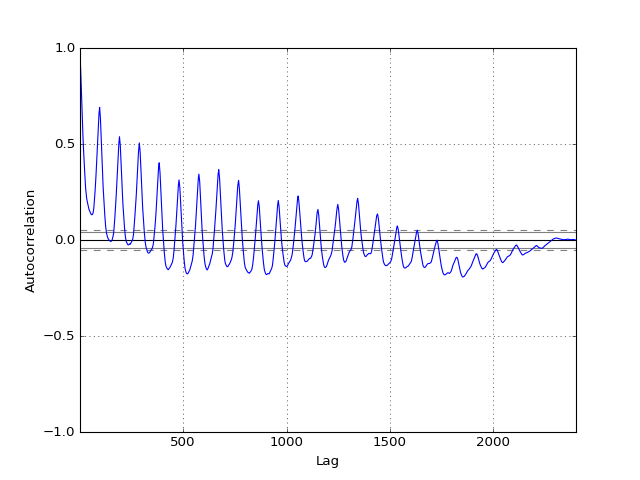

In [29]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(data['belpex'][:24*100])
plt.show()